In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5,6,7,8,9'

In [2]:
from src.ScoreBasedInferenceModel import ScoreBasedInferenceModel as SBIm
from src.plot_functions import *

import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

from scipy.stats import norm

import os
import time as t

from Chempy.parameter import ModelParameters

%matplotlib inline
%load_ext line_profiler

In [3]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [4]:
model = SBIm.load('data/models/optuna_113/Model_checkpoint.pt')
device = "cuda"

In [5]:
# ----- Load the NN -----
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(elements))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x
    
emulator = Model_Torch()
emulator.load_state_dict(torch.load('data/models/pytorch_state_dict_5sigma_uni_prior.pt'))
emulator.eval();

# Simulate data
With the set global priors and for each $N_{\rm stars}$ a set of local priors, we can simulate the data with the Neural Network.

In [6]:
N_stars = 200
simulations = 1000

stars = torch.stack([p.sample_n(N_stars) for p in [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]]+[Uniform(torch.tensor([2.0]), torch.tensor([12.8]))]], dim=0).squeeze().T
global_params = torch.tensor([[-2.3, -2.89]])

stars = torch.cat((global_params.repeat(N_stars, 1), stars), dim=1)

/tmp/ipykernel_1181629/3638983991.py:4: FutureWarning: `sample_n(n)` will be deprecated. Use `sample((n,))` instead.
  stars = torch.stack([p.sample_n(N_stars) for p in [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]]+[Uniform(torch.tensor([2.0]), torch.tensor([12.8]))]], dim=0).squeeze().T


In [7]:
# ----- Simulate abundances -----
start = t.time()
abundances = emulator(stars)  
# Remove H from data, because it is just used for normalization (output with index 2)
abundances = torch.cat([abundances[:,0:2], abundances[:,3:]], axis=1)
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

Time to create data for 200 stars: 0.054 s


# SBI with 5% observation error noise
Need to load the posterior trained with a 5% observation error

In [8]:
def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

In [ ]:
alpha_IMF_obs = []
log10_N_Ia_obs = []
simulations = 1000

mask = torch.zeros(14)
mask[6:] = 1

start = t.time()

x = torch.tensor(add_noise(abundances.detach().numpy()), dtype=torch.float32)
inference = model.sample(x, condition_mask=mask, device=device, num_samples=simulations, timesteps=100, method="euler",multi_obs_inference=True, hierarchy=[0,1], save_trajectory=True)

end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [05:17<14:33,  9.50s/it]   

In [10]:
alpha_IMF_obs, log10_N_Ia_obs = inference[:,:,:2].cpu().T.detach().numpy()

alpha_IMF_obs = alpha_IMF_obs.T
log10_N_Ia_obs = log10_N_Ia_obs.T

/tmp/ipykernel_1116780/943353855.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  alpha_IMF_obs, log10_N_Ia_obs = inference[:,:,:2].cpu().T.detach().numpy()


In [11]:
alpha_IMF_obs

array([[-4.2803733e+19, -3.6137852e+21, -1.5843456e+20, ...,
        -1.6560310e+21, -4.4871181e+21, -5.4337759e+21],
       [-4.2803733e+19, -3.6137852e+21, -1.5843456e+20, ...,
        -1.6560310e+21, -4.4871181e+21, -5.4337759e+21],
       [-4.2803733e+19, -3.6137852e+21, -1.5843456e+20, ...,
        -1.6560310e+21, -4.4871181e+21, -5.4337759e+21],
       ...,
       [-4.2803733e+19, -3.6137852e+21, -1.5843456e+20, ...,
        -1.6560310e+21, -4.4871181e+21, -5.4337759e+21],
       [-4.2803733e+19, -3.6137852e+21, -1.5843456e+20, ...,
        -1.6560310e+21, -4.4871181e+21, -5.4337759e+21],
       [-4.2803733e+19, -3.6137852e+21, -1.5843456e+20, ...,
        -1.6560310e+21, -4.4871181e+21, -5.4337759e+21]], dtype=float32)

In [12]:
alpha_mean = alpha_IMF_obs.mean()
alpha_std = alpha_IMF_obs.std()

logN_Ia_mean = log10_N_Ia_obs.mean()
logN_Ia_std = log10_N_Ia_obs.std()

print(f'alpha_IMF: {alpha_mean:.3f} +- {alpha_std:.3f}')
print(f"True: {global_params[0,0]:.3f}")
print()
print(f'log10_N_Ia: {logN_Ia_mean:.3f} +- {logN_Ia_std:.3f}')
print(f"True: {global_params[0,1]:.3f}")


alpha_IMF: -1850370334999671996416.000 +- inf
True: -2.300

log10_N_Ia: -5661128877346096414720.000 +- inf
True: -2.890


/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [13]:
inference.T.flatten(1).mean(1)

tensor([-1.8504e+21, -5.6611e+21, -1.3462e+00, -3.9039e-01, -3.6343e-01,
         2.5257e+00,  4.6335e-02, -8.8679e-02,  1.1909e-01,  2.7051e-01,
         7.8132e-02,  5.6995e-01,  3.8571e-01,  2.3728e-01], device='cuda:1')

In [14]:
inference.T.flatten(1).std(1)

tensor([   inf,    inf, 1.4011, 1.3991, 1.3984, 1.6254, 0.0675, 0.2886, 0.2668,
        0.0983, 0.0692, 0.0839, 0.1103, 0.0998], device='cuda:1')

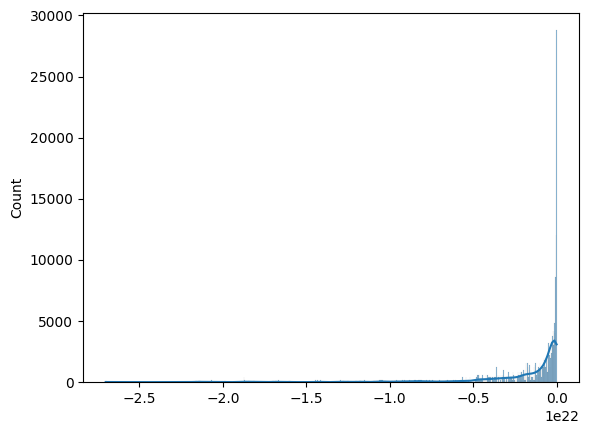

In [15]:
ax = sns.histplot(alpha_IMF_obs.flatten(), bins=1000, kde=True)
plt.show()

In [16]:
ax.lines[0].get_xdata()[np.argmax(ax.lines[0].get_ydata())]

-1.3578194113612952e+20

In [17]:
model.multi_obs_sampler.data_t[0,:,:,0].shape

torch.Size([101, 1000])

In [18]:
test2 = model.multi_obs_sampler.data_t[1,:,:,0].cpu().T.detach().numpy()
test2

array([[ 2.82821512e+00, -2.21772137e+01,  1.59735470e+01, ...,
        -1.76900492e+19, -2.75763937e+19, -4.28037326e+19],
       [ 3.12299766e-02, -1.04475060e+01,  1.84223118e+01, ...,
        -1.49351552e+21, -2.32818846e+21, -3.61378517e+21],
       [-2.95248604e+00,  1.34422159e+00, -1.56945705e+01, ...,
        -6.54782836e+19, -1.02071781e+20, -1.58434559e+20],
       ...,
       [ 2.74157286e+00, -2.43995457e+01,  9.90632439e+00, ...,
        -6.84409221e+20, -1.06690134e+21, -1.65603100e+21],
       [-1.13667047e+00, -6.23580790e+00,  1.17730045e+01, ...,
        -1.85444891e+21, -2.89083499e+21, -4.48711814e+21],
       [ 1.19121201e-01, -1.16772699e+01,  2.50819321e+01, ...,
        -2.24568646e+21, -3.50072117e+21, -5.43377591e+21]], dtype=float32)

In [19]:
test =model.multi_obs_sampler.data_t[0,:,:,0].cpu().T.detach().numpy()
test

array([[ 2.82821512e+00, -2.21772137e+01,  1.59735470e+01, ...,
        -1.76900492e+19, -2.75763937e+19, -4.28037326e+19],
       [ 3.12299766e-02, -1.04475060e+01,  1.84223118e+01, ...,
        -1.49351552e+21, -2.32818846e+21, -3.61378517e+21],
       [-2.95248604e+00,  1.34422159e+00, -1.56945705e+01, ...,
        -6.54782836e+19, -1.02071781e+20, -1.58434559e+20],
       ...,
       [ 2.74157286e+00, -2.43995457e+01,  9.90632439e+00, ...,
        -6.84409221e+20, -1.06690134e+21, -1.65603100e+21],
       [-1.13667047e+00, -6.23580790e+00,  1.17730045e+01, ...,
        -1.85444891e+21, -2.89083499e+21, -4.48711814e+21],
       [ 1.19121201e-01, -1.16772699e+01,  2.50819321e+01, ...,
        -2.24568646e+21, -3.50072117e+21, -5.43377591e+21]], dtype=float32)

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


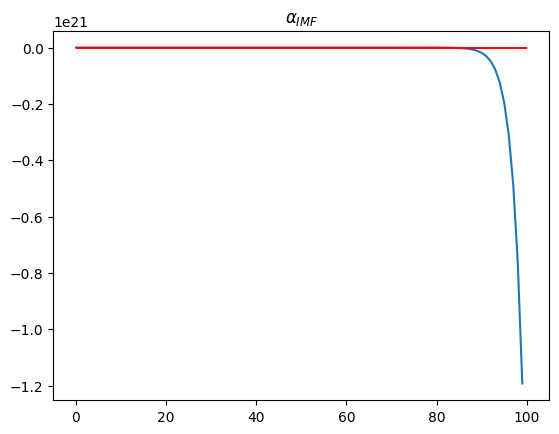

In [20]:
x = np.arange(0,model.multi_obs_sampler.data_t[0,:,:,0].shape[0]-1)
y = model.multi_obs_sampler.data_t[0,:-1,:,0].detach().numpy().mean(axis=1)
yerr = model.multi_obs_sampler.data_t[0,:-1,:,0].detach().numpy().std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.hlines(-2.3, 0, model.multi_obs_sampler.data_t[0,:,:,0].shape[0]-1, color='red')
plt.title(r"$\alpha_{IMF}$")
plt.show()

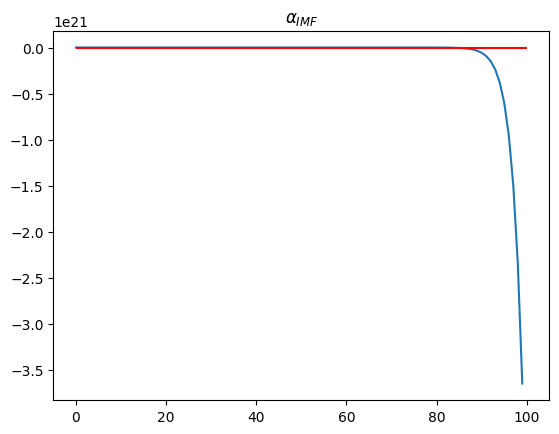

In [21]:
x = np.arange(0,model.multi_obs_sampler.data_t[0,:,:,1].shape[0]-1)
y = model.multi_obs_sampler.data_t[0,:-1,:,1].detach().numpy().mean(axis=1)
yerr = model.multi_obs_sampler.data_t[0,:-1,:,1].detach().numpy().std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.hlines(-2.89, 0, model.multi_obs_sampler.data_t[0,:,:,1].shape[0]-1, color='red')
plt.title(r"$\alpha_{IMF}$")
plt.show()